# Settings

In [1]:
import sys

# set lib path just next to current path to give priority to modules in lib
sys.path.insert(sys.path.index('')+1, '/lib')

In [2]:
%load_ext autotime

import pandas as pd
import FinanceDataReader as fdr

from lib.fastquant import backtest_portfolio
from lib.utils import HiddenPrints, DATE_FORMAT
from datetime import datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

time: 8.07 s (started: 2023-02-23 08:50:30 +09:00)


In [4]:
start = '20180101'
end = '20221231'

symbol = '069500' # KODEX 200
df_all = fdr.DataReader(symbol, start, end)

time: 244 ms (started: 2023-02-23 08:50:39 +09:00)


In [5]:
def run_backtest(start, df_bt, kwargs, proba=1, strategy='custom'):
    
    df = df_bt.copy()
    end = start + timedelta(hold_period)
    df = df.loc[start:end]
    if proba < 1:
        df.loc[:,'custom'] = df.custom.apply(lambda x:x*np.random.choice(2, 1, p=[1.-proba, proba])[0])
    df = {symbol: df}
    with HiddenPrints(mark_end=False):
        result = backtest_portfolio(strategy, df, start.strftime(DATE_FORMAT), end.strftime(DATE_FORMAT), **kwargs)
    if np.isnan(result['history']['win_rate'].squeeze()):
        #return [start, end, None, None, None] # last col 'return' cast to NaT instead of None 
        return [start, end, -1, None, None]
    else:
        return [start, end] + result['summary']
    

def print_progress(i, print_step, last_print):
    n = round((i+1) / n_dates * 100)
    if n != last_print and n % (print_step*100) == 0:
        print(f'{n} % done')
        return n
    else:
        return last_print

time: 2.95 ms (started: 2023-02-23 08:50:40 +09:00)


In [28]:
df_compare = pd.DataFrame()

time: 1.91 ms (started: 2023-02-23 08:54:48 +09:00)


# Buy & hold

## Settings

In [100]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 7.44 ms (started: 2023-02-20 20:03:20 +09:00)


In [101]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 2.07 ms (started: 2023-02-20 20:03:20 +09:00)


In [102]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 957 µs (started: 2023-02-20 20:03:21 +09:00)


In [103]:
# testing
#dates_start = dates_start[:50]

time: 625 µs (started: 2023-02-20 20:03:21 +09:00)


## SC01

In [104]:
scenario = 'b1'
n_buy = 1

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.03 ms (started: 2023-02-20 20:03:23 +09:00)


In [10]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    df_bt.loc[start,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 13min 9s (started: 2023-02-20 17:02:13 +09:00)


In [11]:
df_result['return'].agg(['mean','min','max'])

mean      7.878639
min     -29.578320
max     111.056006
Name: return, dtype: float64

time: 21.5 ms (started: 2023-02-20 17:15:23 +09:00)


In [12]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 8.29 ms (started: 2023-02-20 17:15:23 +09:00)


## SC02

In [13]:
scenario = 'b2'
n_buy = 10

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 5.1 ms (started: 2023-02-20 17:15:23 +09:00)


In [14]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 20

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 13min 51s (started: 2023-02-20 17:15:23 +09:00)


In [15]:
df_result['return'].agg(['mean','min','max'])

mean     3.414606
min    -16.512425
max     38.402674
Name: return, dtype: float64

time: 14.6 ms (started: 2023-02-20 17:29:15 +09:00)


In [16]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 13 ms (started: 2023-02-20 17:29:15 +09:00)


## SC03

In [17]:
scenario = 'b3'
n_buy = 20

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 8.33 ms (started: 2023-02-20 17:29:15 +09:00)


In [18]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

period = 10

for i, start in enumerate(dates_start):
    df_bt['custom'] = 0 # reset
    dt = dates_all[[i + x*period for x in range(n_buy)]]
    df_bt.loc[dt,'custom'] = -1
    
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 15min 15s (started: 2023-02-20 17:29:15 +09:00)


In [19]:
df_result['return'].agg(['mean','min','max'])

mean     3.217287
min    -16.298809
max     36.433602
Name: return, dtype: float64

time: 14.5 ms (started: 2023-02-20 17:44:30 +09:00)


In [20]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15 ms (started: 2023-02-20 17:44:30 +09:00)


## Compare

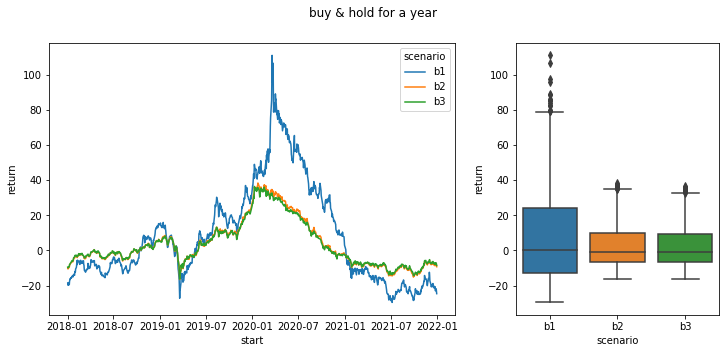

time: 1.21 s (started: 2023-02-20 17:54:16 +09:00)


In [32]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

_ = sns.lineplot(data=df_compare.reset_index(), x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df_compare.reset_index(), x='scenario', y='return', ax=ax2)

In [50]:
#df_compare = df_compare.loc[df_compare.scenario != 't1']
df_compare.to_csv('df_compare.csv')

time: 88.7 ms (started: 2023-02-20 18:22:01 +09:00)


# Technical Indicator

## Settings

In [7]:
import tulipy as ti
import numpy as np

time: 17.8 ms (started: 2023-02-23 08:50:47 +09:00)


In [8]:
def calc_macd(df, periods=[12,26,9]):
    ind = ti.macd(df.astype(float).to_numpy(), *periods)

    name = 'macd'
    cols = [name, name+'_signal', name+'_histogram']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def calc_bbands(df, periods=[20,2]):
    ind = ti.bbands(df.astype(float).to_numpy(), *periods)

    name = 'bbands'
    cols = [name+'_lower', name+'_middle', name+'_upper']
    
    index_size = len(df.index)
    indi = np.full((len(cols), index_size), np.nan)
    indi[:, index_size-ind[0].size:] = ind
    
    return pd.DataFrame(dict(zip(cols, indi)), index=df.index)


def finish_custom(df_bt):
    df = df_bt.copy()
    prv = 0
    for dt, (_, c) in df.iterrows():
        if c in [1, -1]:
            if c == prv:
                df.loc[dt, 'custom'] = 0
            else:
                prv = c
        else:
            prv = 0
    return df


def check_scenario(idx_nobuy, i=None, df_result=None):
    if df_result is None:
        n = len(idx_nobuy)
        if n > 0:
            print(f'{n} scenarios of no buy.')
        return None
    if pd.isnull(df_result.loc[i]['return']):
        idx_nobuy.append(i)
        n = len(idx_nobuy)
        if n < 2:
            print(f'{i}: No buy at all')
        elif n == 2:
            print('there are more scenarios of no buy.')
        else:
            pass
    return idx_nobuy

time: 2.53 ms (started: 2023-02-23 08:50:47 +09:00)


In [9]:
df_bt = (df_all.Close.rename_axis('dt').to_frame('close')
               .assign(custom=0))
dates_all = df_bt.index

time: 12.8 ms (started: 2023-02-23 08:50:48 +09:00)


In [52]:
hold_period = 365
dates_start = df_bt.loc[: dates_all[-1] - timedelta(hold_period)].index
n_dates = dates_start.size

time: 2.07 ms (started: 2023-02-23 09:02:00 +09:00)


In [53]:
kwargs_bt = {
    'init_cash': 1e7, 
    'commission': 0.00363960/100,
    'verbose': False, 
    'plot_bp':False,
    'buy_prop': 1,
    'sell_prop': 1,
    'upper_limit':0.1, 
    'lower_limit':-0.1
}

time: 1.1 ms (started: 2023-02-23 09:02:01 +09:00)


In [70]:
# testing
dates_start = dates_start[400:500]

time: 1.09 ms (started: 2023-02-23 09:45:36 +09:00)


## SC01: MACD

### calc tech indi

In [13]:
df_macd = calc_macd(df_bt['close'])

time: 9.94 ms (started: 2023-02-23 08:50:59 +09:00)


In [14]:
df_ti = df_macd

cond = (df_ti.macd > df_ti.macd_signal) 
cond = cond & (df_ti.macd > 0)
df_bt.loc[cond, 'custom'] = -1

cond = (df_ti.macd < df_ti.macd_signal) 
cond = cond & (df_ti.macd < 0)
df_bt.loc[cond, 'custom'] = 1

time: 16.5 ms (started: 2023-02-23 08:51:00 +09:00)


In [15]:
df_bt = finish_custom(df_bt)

time: 359 ms (started: 2023-02-23 08:51:01 +09:00)


In [54]:
# small number of chance to buy
df_bt.custom.value_counts()

 0    1161
 1      38
-1      33
Name: custom, dtype: int64

time: 20.7 ms (started: 2023-02-23 09:02:08 +09:00)


### bactesting 1

In [55]:
scenario = 't1a'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

time: 6.67 ms (started: 2023-02-23 09:02:10 +09:00)


In [56]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    if pd.isnull(df_result.loc[i]['return']):
        print(f'{i}: No buy at all')

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 13min 33s (started: 2023-02-23 09:02:11 +09:00)


In [57]:
df_result['return'].agg(['mean','min','max'])

mean     8.054669
min    -12.013608
max     57.532363
Name: return, dtype: float64

time: 17.1 ms (started: 2023-02-23 09:15:45 +09:00)


In [58]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 28.4 ms (started: 2023-02-23 09:15:45 +09:00)


### bactesting 2

In [20]:
scenario = 't1b'

kwargs_bt.update({
    'buy_prop': 0.5,
    'sell_prop': 0.5
})

time: 8.99 ms (started: 2023-02-22 20:29:10 +09:00)


In [21]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    if pd.isnull(df_result.loc[i]['return']):
        print(f'{i}: No buy at all')

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 14min 5s (started: 2023-02-22 20:29:10 +09:00)


In [22]:
df_result['return'].agg(['mean','min','max'])

mean     4.636345
min     -6.153420
max     36.403294
Name: return, dtype: float64

time: 13.1 ms (started: 2023-02-22 20:43:16 +09:00)


In [23]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 9.99 ms (started: 2023-02-22 20:43:16 +09:00)


### bactesting 3

In [24]:
scenario = 't1c'

kwargs_bt.update({
    'buy_prop': 0.2,
    'sell_prop': 0.2
})

time: 4.11 ms (started: 2023-02-22 20:43:16 +09:00)


In [25]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)
    if pd.isnull(df_result.loc[i]['return']):
        print(f'{i}: No buy at all')

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
time: 15min 11s (started: 2023-02-22 20:43:16 +09:00)


In [26]:
df_result['return'].agg(['mean','min','max'])

mean     1.854880
min     -3.162596
max     16.136710
Name: return, dtype: float64

time: 11.9 ms (started: 2023-02-22 20:58:28 +09:00)


In [27]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 8.46 ms (started: 2023-02-22 20:58:28 +09:00)


### bactesting 4

In [59]:
scenario = 't1d'

kwargs_bt.update({
    'buy_prop': 1,
    'sell_prop': 1
})

proba = 0.8

time: 1.23 ms (started: 2023-02-23 09:15:45 +09:00)


In [79]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0
idx_nobuy = []

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt, proba)
    n_last = print_progress(i, print_step, n_last)
    idx_nobuy = check_scenario(idx_nobuy, i, df_result)

check_scenario(idx_nobuy)

9: No buy at all
there are more scenarios of no buy.
10 % done
2 scenarios of no buy.
time: 1min 34s (started: 2023-02-23 09:55:06 +09:00)


In [61]:
df_result['return'].agg(['mean','min','max'])

mean     6.475935
min    -27.637768
max     64.466121
Name: return, dtype: float64

time: 14.2 ms (started: 2023-02-23 09:30:33 +09:00)


In [62]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15.4 ms (started: 2023-02-23 09:30:33 +09:00)


### compare

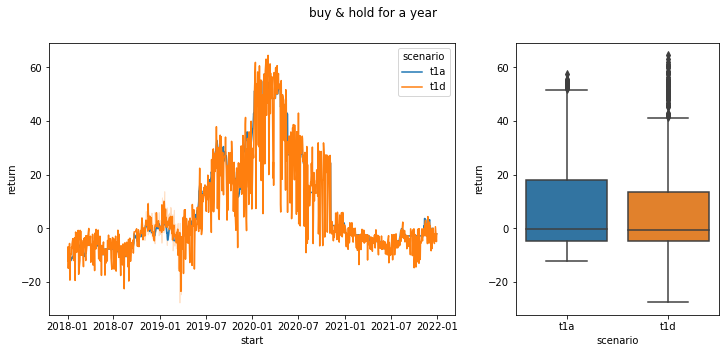

time: 16 s (started: 2023-02-23 09:37:35 +09:00)


In [69]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

#df = df_compare.loc[df_compare['return'].notna()].reset_index()
df = df_compare.dropna(subset='return').reset_index()
_ = sns.lineplot(data=df, x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df, x='scenario', y='return', ax=ax2)

## SC02: Bollinger Bands

### calc tech indi

In [134]:
df_bbands = calc_bbands(df_bt['close'])
#df_bbands = calc_bbands(df_bt['close'], [20, 1])

time: 2.69 ms (started: 2023-02-20 16:56:30 +09:00)


In [128]:
df_ti = df_bbands

cond = df_bt.close < df_ti.bbands_lower
df_bt.loc[cond, 'custom'] = -1

cond = df_bt.close > df_ti.bbands_upper
df_bt.loc[cond, 'custom'] = 1

time: 4.98 ms (started: 2023-02-20 16:55:04 +09:00)


In [129]:
df_bt = finish_custom(df_bt)

time: 165 ms (started: 2023-02-20 16:55:05 +09:00)


### bactesting

In [121]:
scenario = 't2'
n_buy = 50 # krw 200,000 every buy

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.16 ms (started: 2023-02-20 16:51:11 +09:00)


In [130]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
time: 41.8 s (started: 2023-02-20 16:55:12 +09:00)


In [131]:
df_result['return'].agg(['mean','min','max'])

mean   -0.110801
min    -0.406478
max    -0.046123
Name: return, dtype: float64

time: 14.5 ms (started: 2023-02-20 16:55:55 +09:00)


In [132]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15.6 ms (started: 2023-02-20 16:55:58 +09:00)


## SC03: Bollinger Bands & MACD

In [146]:
df_macd = calc_macd(df_bt['close'])
calc_bbands = calc_macd(df_bt['close'])

time: 4 ms (started: 2023-02-20 17:00:10 +09:00)


In [147]:
cond = (df_macd.macd > df_macd.macd_signal) & (df_macd.macd > 0)
cond = cond + (df_bt.close < df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = -1

cond = (df_macd.macd < df_macd.macd_signal) & (df_macd.macd < 0)
cond = cond + (df_bt.close > df_bbands.bbands_lower)
df_bt.loc[cond, 'custom'] = 1

time: 19.4 ms (started: 2023-02-20 17:00:13 +09:00)


In [148]:
df_bt = finish_custom(df_bt)

time: 271 ms (started: 2023-02-20 17:00:15 +09:00)


### bactesting

In [149]:
scenario = 't3'
n_buy = 50 # krw 200,000 every buy

kwargs_bt.update({
    'buy_prop': 1/n_buy,
})

time: 1.12 ms (started: 2023-02-20 17:00:19 +09:00)


In [150]:
df_result = pd.DataFrame(columns=['start', 'end', 'init', 'final', 'return'])
print_step = 0.1
n_last = 0

for i, start in enumerate(dates_start):
    df_result.loc[i] = run_backtest(start, df_bt, kwargs_bt)
    n_last = print_progress(i, print_step, n_last)

10 % done
20 % done
time: 41.1 s (started: 2023-02-20 17:00:20 +09:00)


In [151]:
df_result['return'].agg(['mean','min','max'])

mean   -0.015555
min    -0.029766
max     0.008556
Name: return, dtype: float64

time: 20.1 ms (started: 2023-02-20 17:01:01 +09:00)


In [132]:
df = df_result.set_index('start').loc[:,'return'].to_frame().assign(scenario=scenario)
df_compare = pd.concat([df_compare, df]) 

time: 15.6 ms (started: 2023-02-20 16:55:58 +09:00)


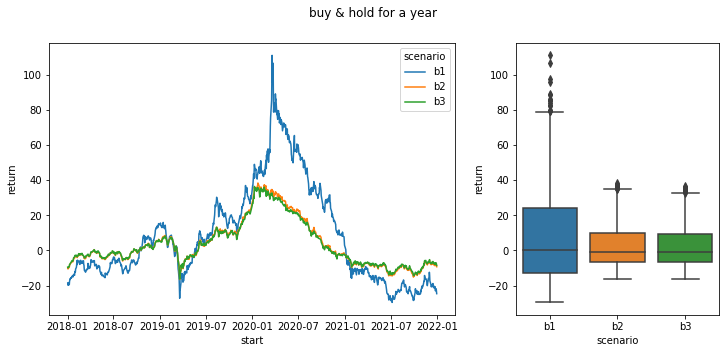

time: 1.21 s (started: 2023-02-20 17:54:16 +09:00)


In [32]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

_ = sns.lineplot(data=df_compare.reset_index(), x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df_compare.reset_index(), x='scenario', y='return', ax=ax2)

# Comparison

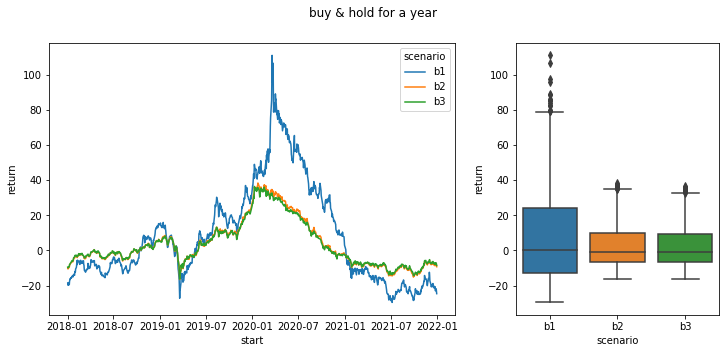

time: 1.21 s (started: 2023-02-20 17:54:16 +09:00)


In [32]:
fig = plt.figure(figsize=(12, 5))
fig.suptitle("buy & hold for a year")
gs = GridSpec(1, 2, width_ratios=[2, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

_ = sns.lineplot(data=df_compare.reset_index(), x='start', y='return', hue='scenario', ax=ax1)
_ = sns.boxplot(data=df_compare.reset_index(), x='scenario', y='return', ax=ax2)